In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.datasets import dump_svmlight_file
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.model_selection import GroupShuffleSplit

from sklearn.metrics import ndcg_score

import tensorflow as tf
from tensorflow.keras import layers, models

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df_amenities = pd.read_csv('/content/drive/My Drive/Expedia/Data/exploded_df_100Krows_Top500Destinations__LeftJoin_Amenities_NaHandled_17April.csv')

In [4]:
for i,j in df_amenities.iterrows():
  if (j['num_clicks'] > 0) & (j['is_trans'] == 0):
    df_amenities.at[i,'relevance'] = 1
  elif (j['num_clicks'] > 0) & (j['is_trans'] > 0):
    df_amenities.at[i,'relevance'] = 2
  else:
    df_amenities.at[i,'relevance'] = 0

df_amenities['relevance'].value_counts()

relevance
0.0    195442
1.0     13546
2.0       993
Name: count, dtype: int64

In [5]:
df_amenities.head()

,user_id,search_id,point_of_sale,geo_location_country,is_mobile,destination_id,checkin_date,checkout_date,adult_count,child_count,infant_count,room_count,sort_type,length_of_stay,booking_window,search_day_of_week,search_hour_of_day,checkin_day,checkout_day,rank,prop_id,is_travel_ad,review_rating,review_count,star_rating,is_free_cancellation,is_drr,price_bucket,num_clicks,is_trans,rank_noad,AirConditioning,AirportTransfer,Bar,FreeAirportTransportation,FreeBreakfast,FreeParking,FreeWiFi,Gym,HighSpeedInternet,HotTub,LaundryFacility,Parking,PetsAllowed,PrivatePool,SpaServices,SwimmingPool,WasherDryer,WiFi,relevance
0,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,1,1624072,0,4.0,1250.0,4.0,1,1,2.0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,2,5170759,1,4.0,1025.0,3.0,0,0,1.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,3,1342604,1,4.0,1375.0,4.0,1,1,4.0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,4,5866319,0,4.0,2225.0,4.0,1,1,1.0,0,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2,2,1,1,0,49,2021-07-07,2021-07-12,2,0,0,1,RECOMMENDED,5.0,26.0,3,0,2,2,5,2935403,0,5.0,1050.0,4.0,1,1,2.0,0,0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def split_by_qid(df2, test_size):
    gss = GroupShuffleSplit(test_size=test_size, n_splits=1, random_state=42)
    ids = df2['search_id'].unique()
    train_idx, test_idx = next(gss.split(ids, groups=ids))
    return df2[df2['search_id'].isin(ids[train_idx])], df2[df2['search_id'].isin(ids[test_idx])]

train_df, temp_df = split_by_qid(df_amenities, test_size=0.4)
val_df, test_df = split_by_qid(temp_df, test_size=0.5)

train_df.shape, val_df.shape, test_df.shape

((126060, 50), (42075, 50), (41846, 50))

In [7]:
train_df.drop(columns=['user_id','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'prop_id'], inplace=True)
val_df.drop(columns=['user_id','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'prop_id'], inplace=True)
test_df.drop(columns=['user_id','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'prop_id'], inplace=True)

train_df.shape, val_df.shape, test_df.shape

<ipython-input-7-10aee2fb5569>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=['user_id','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'prop_id'], inplace=True)
<ipython-input-7-10aee2fb5569>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.drop(columns=['user_id','checkin_date','checkout_date','rank_noad','rank','num_clicks','is_trans', 'prop_id'], inplace=True)
<ipython-input-7-10aee2fb5569>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

((126060, 42), (42075, 42), (41846, 42))

In [8]:
X_train_t = train_df.drop(columns=['relevance'])
y_train = train_df['relevance']

X_val_t = val_df.drop(columns=['relevance'])
y_val = val_df['relevance']

X_test_t = test_df.drop(columns=['relevance'])
y_test = test_df['relevance']

query_id_train = X_train_t['search_id']

query_id_val = X_val_t['search_id']

query_id_test = X_test_t['search_id']

In [9]:
object_col = ['point_of_sale', 'geo_location_country', 'is_mobile', 'destination_id','sort_type', 'search_day_of_week','search_hour_of_day', 'checkin_day', 'checkout_day', 'is_travel_ad',
              'review_rating','star_rating','is_free_cancellation', 'is_drr', 'AirConditioning', 'AirportTransfer', 'Bar', 'FreeAirportTransportation', 'FreeBreakfast', 'FreeParking', 'FreeWiFi',
              'Gym', 'HighSpeedInternet', 'HotTub', 'LaundryFacility', 'Parking', 'PetsAllowed', 'PrivatePool', 'SpaServices', 'SwimmingPool', 'SpaServices', 'WasherDryer', 'WiFi']

for i in object_col:
  X_train_t[i]=X_train_t[i].astype('object')

for i in object_col:
  X_val_t[i]=X_train_t[i].astype('object')

for i in object_col:
  X_test_t[i]=X_test_t[i].astype('object')

In [10]:
categorical_features = X_train_t.select_dtypes(include=['object']).columns.tolist()
numeric_features = X_train_t.select_dtypes(exclude=['object']).columns.tolist()

numeric_features.remove('search_id')
numeric_features

['adult_count',
 'child_count',
 'infant_count',
 'room_count',
 'length_of_stay',
 'booking_window',
 'review_count',
 'price_bucket']

In [11]:
combined_df = pd.concat([X_train_t, X_val_t, X_test_t])
combined_df = pd.get_dummies(combined_df, columns=categorical_features)

combined_df.shape

(209981, 742)

In [12]:
X_train = combined_df[:len(X_train_t)]
X_val = combined_df[len(X_train_t):len(X_train_t)+len(X_val_t)]
X_test = combined_df[len(X_train_t)+len(X_val_t):]

X_train.shape, X_val.shape, X_test.shape

((126060, 742), (42075, 742), (41846, 742))

In [13]:
scaler=StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val[numeric_features] = scaler.fit_transform(X_val[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

<ipython-input-13-03753182f5e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
<ipython-input-13-03753182f5e6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[numeric_features] = scaler.fit_transform(X_val[numeric_features])
<ipython-input-13-03753182f5e6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

### MSE LOSS FUNCTION

In [14]:
loss_fn_mse = 'mse'

### RANKNET LOSS FUNCTION

In [15]:
def ranknet_loss(y_true, y_pred):
    # Compute pairwise differences in predicted scores
    diff = tf.expand_dims(y_pred, axis=1) - tf.expand_dims(y_pred, axis=0)

    # Compute the sigmoid function of the differences
    sigma = tf.math.sigmoid(diff)

    # Clip values of sigma to avoid log(0) or log(1)
    sigma = tf.clip_by_value(sigma, clip_value_min=1e-7, clip_value_max=1-1e-7)

    # Create a mask to zero out comparisons between identical items
    mask = tf.eye(tf.shape(sigma)[0])
    masked_sigma = sigma * (1 - mask)

    # Compute the RankNet loss
    loss = -tf.reduce_mean(masked_sigma * tf.math.log(sigma) + (1 - masked_sigma) * tf.math.log(1 - sigma))

    return loss

### SOFTRANK LOSS METRIC

In [16]:
def softrank_loss(y_true, y_pred):
    """
    SoftRank loss function for learning-to-rank.

    Args:
    - y_true: True labels (ground truth)
    - y_pred: Predicted scores

    Returns:
    - Loss value
    """
    # Cast y_true to float32
    y_true = tf.cast(y_true, tf.float32)

    # Compute pairwise differences in predicted scores
    diff = tf.expand_dims(y_pred, axis=1) - tf.expand_dims(y_pred, axis=0)

    # Compute pairwise probabilities
    sigma = tf.math.sigmoid(diff)

    # Compute pairwise cross-entropy loss
    loss = -tf.reduce_mean(y_true * tf.math.log(sigma + 1e-10) + (1 - y_true) * tf.math.log(1 - sigma + 1e-10))

    return loss

### NDCG METRIC

In [28]:
def ndcg(y_score, y_true, k):
    order = tf.argsort(y_score, direction='DESCENDING')
    y_true = tf.gather(y_true, order[:k], axis=1)

    gain = tf.pow(2.0, y_true) - 1

    discounts = tf.math.log(tf.cast(tf.range(1, k + 1), tf.float32) + 1.0) / tf.math.log(2.0)
    return tf.reduce_sum(gain / discounts, axis=1)


def ndcg_metric(y_true, y_pred):
    k = 30  # Define your value of k
    idcg = ndcg(y_true, y_true, k)
    return tf.reduce_mean(ndcg(y_pred, y_true, k=30) / idcg)

In [ ]:
def ndcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


qids = np.unique(query_id_val)

ndcg_ = list()

for i, qid in enumerate(qids):
    y = y_val[query_id_val == qid]

    if np.sum(y) == 0:
        continue

    X_val1 = X_val[X_val['search_id'] == qid]

    X_val_2 = X_val1.drop(columns=['search_id'])
    X_val_arr = X_val_2.values.astype(int)

    p = model.predict(X_val_arr, verbose=False)
    p = p.flatten()

    idcg = ndcg(y, y, k=30)
    ndcg_.append(ndcg(p, y, k=30) / idcg)

np.mean(ndcg_)

In [17]:
def ndcg(y_score, y_true, k):
    order = tf.argsort(y_score, direction='DESCENDING')
    y_true = tf.gather(y_true, order[:k], axis=1)

    gain = tf.pow(2.0, y_true) - 1

    discounts = tf.math.log(tf.cast(tf.range(1, k + 1), tf.float32) + 1.0) / tf.math.log(2.0)
    return tf.reduce_sum(gain / discounts, axis=1)

def ndcg_metric(y_true, y_pred):
    k = 30  # Define your value of k
    ndcg_value = ndcg(y_pred, y_true, k)
    return tf.reduce_mean(ndcg_value)

In [30]:
def ndcg(y_score, y_true, k):
    order = tf.argsort(y_score, direction='DESCENDING')
    y_true = tf.gather(y_true, order[:k], axis=0)

    gain = tf.pow(2.0, y_true) - 1

    discounts = tf.math.log(tf.cast(tf.range(1, k + 1), tf.float32) + 2.0) / tf.math.log(2.0)
    return tf.reduce_sum(gain / discounts)

# Define the custom metric function
def ndcg_metric(y_true, y_pred):
    # Assuming y_true is the ground truth and y_pred is the predicted scores
    k = 30  # Define the value of k
    return tf.py_function(ndcg, [y_pred, y_true, k], tf.float32)


In [34]:
def ndcg(y_score, y_true, k):
    order = tf.argsort(y_score, direction='DESCENDING')
    y_true_sorted = tf.gather(y_true, order, axis=0)

    gain = 2 ** y_true_sorted - 1

    discounts = tf.math.log(tf.cast(tf.range(1, k + 1), tf.float32) + 1.0) / tf.math.log(2.0)
    dcg = tf.reduce_sum(gain / discounts, axis=1)

    # Ideal Discounted Cumulative Gain (IDCG)
    ideal_order = tf.argsort(y_true, direction='DESCENDING')
    ideal_gain = 2 ** tf.gather(y_true, ideal_order, axis=0) - 1
    ideal_dcg = tf.reduce_sum(ideal_gain / discounts, axis=1)

    # Normalized Discounted Cumulative Gain (NDCG)
    ndcg = dcg / ideal_dcg
    return ndcg


def ndcg_metric(y_true, y_pred):
    # Assuming y_true is the ground truth and y_pred is the predicted scores
    k = 30  # Define the value of k
    return tf.py_function(ndcg, [y_pred, y_true, k], tf.float32)

### NN ARCHITECTURE

In [ ]:
!pip install tensorflow-ranking

In [18]:
import tensorflow_ranking as tfr

In [35]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_ndcg_metric', mode='max')

X_train_2 = X_train.drop(columns=['search_id'])
X_train_arr = X_train_2.values.astype(int)
y_train_array = y_train.values.ravel()

X_val_2 = X_val.drop(columns=['search_id'])
X_val_arr = X_val_2.values.astype(int)
y_val_array = y_val.values.ravel()

np.random.seed(42)
tf.random.set_seed(42)

# Define the architecture of the neural network
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_arr.shape[1],)),
    #layers.Dense(128, activation='relu'),
    #layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer with linear activation for ranking scores
])

# Choose an appropriate optimizer and loss function
loss = tfr.keras.losses.ApproxNDCGLoss(temperature=0.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[ndcg_metric, 'accuracy'])

# Train the model
history = model.fit(X_train_arr, y_train_array,
                    epochs=30, validation_data=[X_val_arr, y_val_array],
                    verbose=True, callbacks=[early_stopping_cb]
                    )  # Using validation split
history

Epoch 1/30
3940/3940 [==============================] - 39s 9ms/step - loss: -0.0684 - ndcg_metric: nan - accuracy: 0.9316 - val_loss: -0.0718 - val_ndcg_metric: nan - val_accuracy: 0.9282
Epoch 2/30
3940/3940 [==============================] - 37s 9ms/step - loss: -0.0684 - ndcg_metric: nan - accuracy: 0.9316 - val_loss: -0.0718 - val_ndcg_metric: nan - val_accuracy: 0.9282
Epoch 3/30
3940/3940 [==============================] - 33s 8ms/step - loss: -0.0684 - ndcg_metric: nan - accuracy: 0.9316 - val_loss: -0.0718 - val_ndcg_metric: nan - val_accuracy: 0.9282
Epoch 4/30
3940/3940 [==============================] - 34s 9ms/step - loss: -0.0684 - ndcg_metric: nan - accuracy: 0.9316 - val_loss: -0.0718 - val_ndcg_metric: nan - val_accuracy: 0.9282
Epoch 5/30
3940/3940 [==============================] - 36s 9ms/step - loss: -0.0684 - ndcg_metric: nan - accuracy: 0.9316 - val_loss: -0.0718 - val_ndcg_metric: nan - val_accuracy: 0.9282


In [37]:
pip install tensorflow

In [39]:
from tensorflow.keras.layers import Input, Concatenate, Embedding, Dense
from tensorflow.keras.models import Model

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='mae', mode='max')

# Input layers for features and search_id
input_features = Input(shape=(X_train_arr.shape[1],), name='features')
input_query_id = Input(shape=(1,), name='search_id')

# Embedding or concatenation layer for search_id
# Example using concatenation:
concatenated_inputs = Concatenate()([input_features, input_query_id])

# Example using embedding:
# embedding_layer = Embedding(input_dim=num_unique_query_ids, output_dim=embedding_dim)(input_query_id)
# flattened_embedding = Flatten()(embedding_layer)
# concatenated_inputs = Concatenate()([input_features, flattened_embedding])

# Define the rest of your model architecture
dense_layer_1 = Dense(64, activation='relu')(concatenated_inputs)
dense_layer_2 = Dense(32, activation='relu')(dense_layer_1)
output_layer = Dense(1, activation='linear')(dense_layer_2)

# Define the model
model = Model(inputs=[input_features, input_query_id], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model with both features and search_id
history = model.fit({'features': X_train_arr, 'search_id': query_id_train}, y_train_array,
                    epochs=30, validation_data=({'features': X_val_arr, 'search_id': query_id_val}, y_val_array),
                    verbose=True, callbacks=[early_stopping_cb])

Epoch 1/30
3940/3940 [==============================] - 16s 4ms/step - loss: 888.1544 - mae: 4.0039 - val_loss: 0.6713 - val_mae: 0.6783
Epoch 2/30
3940/3940 [==============================] - 14s 4ms/step - loss: 120.2319 - mae: 3.1564 - val_loss: 0.6942 - val_mae: 0.7153
Epoch 3/30
3940/3940 [==============================] - 13s 3ms/step - loss: 59.1854 - mae: 2.3409 - val_loss: 0.9248 - val_mae: 0.8223
Epoch 4/30
3940/3940 [==============================] - 14s 4ms/step - loss: 44.0007 - mae: 2.0198 - val_loss: 0.0945 - val_mae: 0.1232
Epoch 5/30
3940/3940 [==============================] - 13s 3ms/step - loss: 43.6882 - mae: 1.6307 - val_loss: 0.5797 - val_mae: 0.6272
Epoch 6/30
3940/3940 [==============================] - 13s 3ms/step - loss: 16.9366 - mae: 1.3329 - val_loss: 0.1372 - val_mae: 0.2943


In [53]:
X_test_2 = X_test.drop(columns=['search_id'])  # Remove 'search_id' column if present
X_test_arr = X_test_2.values.astype(int)  # Convert to numpy array
query_id_test_arr = query_id_test.values.reshape(-1, 1)  # Reshape query IDs to match the shape of input_query_id

# Perform predictions on test data
predictions = model.predict({'features': X_test_arr, 'search_id': query_id_test_arr})

# Flatten the predictions if necessary
predictions = predictions.flatten()

len(predictions)

1308/1308 [==============================] - 2s 2ms/step


41846

In [73]:
def ndcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

In [81]:
qids = np.unique(query_id_test)

ndcg_ = list()

for i, qid in enumerate(qids[:]):
    y = y_test[query_id_test == qid]

    if np.sum(y) == 0:
        continue

    X_test1 = X_test[X_test['search_id'] == qid]
    qid_test = X_test1['search_id']
    X_test1 = X_test1.drop(columns=['search_id'])

    X_test_arr = X_test1.values.astype(int)
    query_id_test_arr = qid_test.values.astype(int)

    predictions = model.predict({'features': X_test_arr, 'search_id': query_id_test_arr}, verbose=False)
    predictions = predictions.flatten()

    idcg = ndcg(y, y, k=30)
    ndcg_.append(ndcg(predictions, y, k=30) / idcg)

np.mean(ndcg_)

0.3873868258980352

In [58]:
def ndcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


qids = np.unique(query_id_val)

ndcg_ = list()

for i, qid in enumerate(qids):
    y = y_test[query_id_test == qid]

    if np.sum(y) == 0:
        continue

    X_val1 = X_val[X_val['search_id'] == qid]

    X_val_2 = X_val.drop(columns=['search_id'])
    X_val_arr = X_val_2.values.astype(int)
    query_id_val_arr = query_id_val.values.astype(int)

    p = model.predict({'features': X_test_arr, 'search_id': query_id_test_arr})
    p = p.flatten()

    idcg = ndcg(y, y, k=30)
    ndcg_.append(ndcg(p, y, k=30) / idcg)

np.mean(ndcg_)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

In [49]:
ndcg_ = []

for qid in qids:
    # Filter data corresponding to the current query ID
    mask = (query_id_val == qid)
    y = y_val[mask]
    X_val_subset = X_val[mask]

    if np.sum(y) == 0:
        continue

    X_val_subset_arr = X_val_subset.values.astype(float)  # Convert to float if necessary
    query_id_val_arr = np.full_like(y, qid, dtype=int)

    # Create a dictionary with input data
    input_data = {'features': X_val_subset_arr, 'search_id': query_id_val_arr}

    # Use the input dictionary when calling model.predict
    p = model.predict(input_data, verbose=False).flatten()

    idcg = ndcg(y, y, k=30)
    ndcg_.append(ndcg(p, y, k=30) / idcg)

mean_ndcg = np.mean(ndcg_)

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 741), found shape=(None, 742)


In [45]:
query_id_val

238         113
239         113
240         113
241         113
242         113
          ...  
209778    99863
209779    99863
209780    99863
209781    99863
209782    99863
Name: search_id, Length: 42075, dtype: int64

### EVALUATION TRAIN AND VAL LOSS

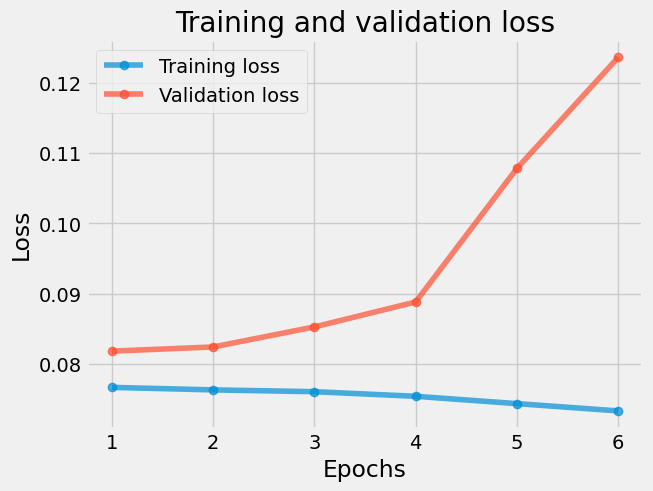

In [357]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.style.use('fivethirtyeight')
plt.plot(epochs, train_loss, label='Training loss', marker='o', alpha=0.7)
plt.plot(epochs, val_loss, label='Validation loss', marker='o', alpha=0.7)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### TEST PREDICTIONS AND EVALUATION

In [358]:
X_test_2 = X_test.drop(columns=['search_id'])
X_test_arr = X_test_2.values.astype(int)
y_test_array = y_test.values.ravel()

test_loss = model.evaluate(X_test_arr, y_test_array)

predictions = model.predict(X_test_arr.astype(float))

predictions = predictions.reshape(-1)

test_df['predicted_score'] = predictions

y_test_df = pd.DataFrame({'relevance_score': y_test, 'predicted_ranking': predictions})
y_test_df.head()

1308/1308 [==============================] - 2s 1ms/step


<ipython-input-358-c8c51102caab>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_score'] = predictions


,relevance_score,predicted_ranking
0,1.0,0.117271
1,0.0,0.120173
2,0.0,0.103796
3,0.0,0.161382
4,0.0,0.111887


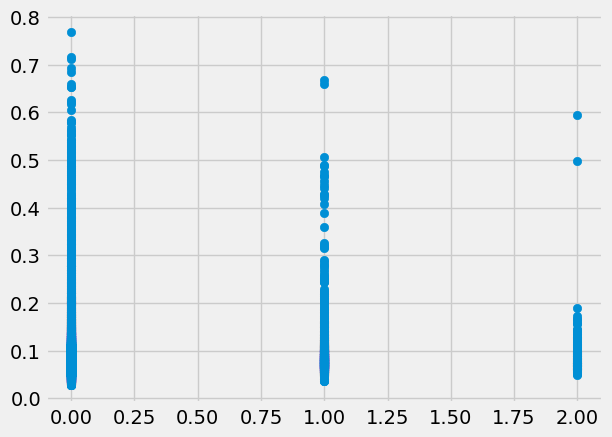

In [345]:
plt.style.use('fivethirtyeight')
plt.scatter(y_test_df["relevance_score"], y_test_df["predicted_ranking"])
plt.show()

In [346]:
print('Mean predicted score for 0 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 0]['predicted_ranking']))
print('Mean predicted score for 1 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 1]['predicted_ranking']))
print('Mean predicted score for 2 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 2]['predicted_ranking']))
print('Mean predicted score for 3 relevance values:',np.mean(y_test_df[y_test_df['relevance_score'] == 3]['predicted_ranking']))

Mean predicted score for 0 relevance values: 0.081629366
Mean predicted score for 1 relevance values: 0.0882183
Mean predicted score for 2 relevance values: 0.08923919
Mean predicted score for 3 relevance values: nan


In [337]:
ndcg_noad_nn_all = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores])
    ndcg_noad_nn_all.append(ndcg)

print('NDCG mean taking into account all values of the ranking', np.mean(ndcg_noad_nn_all))

NDCG mean taking into account all values of the ranking 0.32403404957409676


In [338]:
ndcg_noad_nn_k20 = []
for group_name, group_df in test_df.groupby('search_id'):
    pred_scores = group_df['predicted_score']
    true_labels = sorted(group_df['relevance'],reverse=True)
    ndcg = ndcg_score([true_labels], [pred_scores], k=20)
    ndcg_noad_nn_k20.append(ndcg)

print('NDCG mean taking into account the first 20 values of the ranking', np.mean(ndcg_noad_nn_k20))

NDCG mean taking into account the first 20 values of the ranking 0.21053643808607797


### TEST EVALUATION NEW NDCG FUNCTION

In [20]:
def ndcg(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

In [21]:
qids = np.unique(query_id_test)

ndcg_ = list()

for i, qid in enumerate(qids):
    y = y_test[query_id_test == qid]

    #if np.sum(y) == 0:
    #    continue

    X_test1 = X_test[X_test['search_id'] == qid]

    X_test_2 = X_test1.drop(columns=['search_id'])
    X_test_arr = X_test_2.values.astype(int)

    p = model.predict(X_test_arr, verbose=False)
    p = p.flatten()

    idcg = ndcg(y, y, k=30)
    ndcg_.append(ndcg(p, y, k=30) / idcg)

np.mean(ndcg_)

0.3871069047868138

In [ ]:
mse_r = [0.43]
ranknet_r = [0.39]
softrank_r = [0.35]